In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt

from IPython.core.debugger import set_trace

total_pattern = re.compile('(\S+)\s+(\S+)')
pattern = re.compile('(\S+)\s+(\S+)\s+(\S+)')

In [2]:
feats = pd.read_csv("../System/feats_train.csv")
af = feats.loc[feats['class'] == 1]
naf = feats.loc[feats['class'] == 0]

feats.head()

,index,superlatives,degree_adverbs,comparative_adverbs,proper_nouns,dates,numbers,fp_pronouns,negations,pos_emotion,...,ap_num,ap_date,ap_title,alliteration,profanity,lexical_diversity,lexical_density,function_words,spelling_errors,class
0,1,0.002488,0.200000,0.133333,0.224000,0.000000,0.012438,0.230769,0.000000,0.009950,...,0.0,1.0,1.0,0.000000,0.000000,0.613692,0.589242,0.410758,0.029340,1
1,2,0.000000,0.047619,0.047619,0.170940,0.000000,0.000000,0.545455,0.010471,0.002618,...,0.0,1.0,1.0,0.166667,0.002577,0.590206,0.597938,0.402062,0.064433,1
2,3,0.004255,0.111111,0.000000,0.163934,0.017021,0.008511,0.125000,0.017021,0.017021,...,0.0,1.0,1.0,0.000000,0.000000,0.566667,0.575000,0.425000,0.016667,1
3,4,0.000000,0.083333,0.000000,0.266667,0.000000,0.037037,0.000000,0.005291,0.015873,...,1.0,1.0,0.0,0.666667,0.000000,0.708333,0.604167,0.395833,0.156250,1
4,5,0.002066,0.000000,0.000000,0.152866,0.004132,0.035124,0.555556,0.002066,0.004132,...,1.0,1.0,1.0,0.000000,0.000000,0.529532,0.610998,0.389002,0.042770,1


In [3]:
superlatives = r'DAT|JJT|RGT|RRT'
degree_adverbs = r'RG(QV?|R|T)?'
comparative_adverbs = r'RGR|RRR'
proper_nouns = r'NP[12]'
dates = r'NP(D[12]|M[12])'
numbers = r'M[CDF]\w*'
fp_pronouns = r'PPI\w+'
negations = r'XX'

all_emotion = r'E[\w\.\+-]+'
emotion_general = r'E1[\+-]'
pos_emotion = r'E[2-6](\.[12])?\++'
neg_emotion = r'E[2-6](\.[12])?-+'
time_related = r'T[1-4][\.\d\+-]*'
sense_words = r'X3[\.\d\+-]*'
movement_words = r'M[1-6]'
relationships = r'S3.*'

spatial_words = r'RL|ND1|NNL[12]|M[78]'

# Imagination subject to change
inf_conjunctions = r'CC'
ima_conjunctions = r'CCB|CS'
conjunctions = r'C\w+'
inf_verb = r'VVN'
ima_verb = r'VV[^N]\w?|VM'
verbs = r'V\w+'
prepositions = r'I\w+'
articles = r'A\w+'
ima_determiners = r'DA1|DB\w?'
determiners = r'D\w+'
adjectives = r'J\w+'
nouns = r'N\w+'
pronouns = r'P\w+'
adverbs = r'R\w+'

exaggeration = r'A13\.[237]'    # Boosters, Maximisers, and Minimisers.
vague_degree = r'A13\.[145]'    # Non-specific, Approximators, Compromisers

re_punctuation = r'[\.\,\"\'\“\”\`\!\?]+'

In [4]:
def find_punctuation(indices):
    counts = dict()
    for i in indices:
        with open("../Tagged_Corpus/{0}h/{0}h.txt".format(i)) as pos_file:
            text = pos_file.read().strip()
            instances = re.findall(re_punctuation, text)
            for p in instances:
                if p in counts:
                    counts[p] += (1 / len(text) / len(indices) * 100)
                else:
                    counts[p] = (1 / len(text) / len(indices) * 100)
                    
    return counts

def find_common_tags(regex, indices):
    directory = "../Tagged_Corpus"
    tags = dict()
    for i in indices:
        with open("../Tagged_Corpus/{0}/{0}.txt.pos.sem.wap.fql".format(i)) as pos_file:
            lines = [line.strip() for line in pos_file]
            t = total_pattern.match(lines[0])
            total = int(t.group(2).strip())
            for line in lines:
                curr = line.strip()
                m = pattern.match(curr)
                
                if not m: continue
                
                word = m.group(1)
                tag = m.group(2)
                count = int(m.group(3)) / total / len(indices) * 100
                
                if tag in tags:
                    tags[tag].append((word, count))
                else:
                    tags[tag]= [(word, count)]
                        
        with open("../Tagged_Corpus/{0}/{0}.txt.pos.sem.was.fql".format(i)) as sem_file:
            lines = [line.strip() for line in sem_file]
            t = total_pattern.match(lines[0])
            total = int(t.group(2).strip())
            for line in lines:
                curr = line.strip()
                m = pattern.match(curr)
                
                if not m: continue
                
                word = m.group(1)
                tag = m.group(2)
                count = int(m.group(3)) / total / len(indices) * 100
                
                if tag in tags:
                    tags[tag].append((word, count))
                else:
                    tags[tag]= [(word, count)]
                    
        words = []
        for tag in tags:
            if re.fullmatch(regex, tag):
                for word in tags[tag]:
                    words.append(word)
                        
    return words

In [5]:
target_tag = proper_nouns
target_tag

'NP[12]'

In [6]:
af_words = find_common_tags(target_tag, af.index.values + 1)

af_words_pd = pd.DataFrame(af_words, columns=['word','af_count'])
af_words_pd = af_words_pd.groupby('word').sum()

af_words_pd.sort_values("af_count", ascending=False)

,af_count
word,
Microsoft,0.055849
Google,0.044950
Disney,0.035807
Nintendo,0.033121
US,0.029819
Mac,0.020857
OS,0.019520
UK,0.018745
Facebook,0.018276


In [7]:
naf_words = find_common_tags(target_tag, naf.index.values + 1)

naf_words_pd = pd.DataFrame(naf_words, columns=['word','naf_count'])
naf_words_pd = naf_words_pd.groupby('word').sum()

naf_words_pd.sort_values("naf_count", ascending=False)

,naf_count
word,
U.S.,0.092087
US,0.068383
United_States,0.051185
China,0.042977
Obama,0.035910
UK,0.033232
America,0.027868
Iraq,0.022478
New_York,0.022390


In [8]:
word_freqs = af_words_pd.join(naf_words_pd, how='outer')
word_freqs = word_freqs.fillna(0)

word_freqs = word_freqs.sort_values("naf_count", ascending=False)
word_freqs

,af_count,naf_count
word,,
U.S.,0.011355,0.092087
US,0.029819,0.068383
United_States,0.015826,0.051185
China,0.011297,0.042977
Obama,0.007103,0.035910
UK,0.018745,0.033232
America,0.016906,0.027868
Iraq,0.002396,0.022478
New_York,0.010684,0.022390


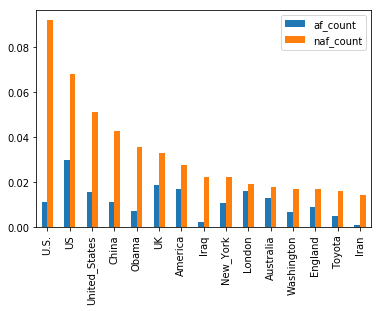

In [9]:
fig, ax = plt.subplots()

top_20 = word_freqs.head(15)
top_20.plot.bar(ax=ax)
ax.xaxis.label.set_visible(False)
plt.show()

In [10]:
af_punct = find_punctuation(af.index.values + 1)
naf_punct = find_punctuation(naf.index.values + 1)

In [11]:
af_punct_pd = pd.DataFrame.from_dict(af_punct, orient='index')
af_punct_pd.columns = ['af_count']
af_punct_pd = af_punct_pd.sort_values('af_count', ascending=False)

naf_punct_pd = pd.DataFrame.from_dict(naf_punct, orient='index')
naf_punct_pd.columns = ['naf_count']
naf_punct_pd = naf_punct_pd.sort_values('naf_count', ascending=False)

punct_freqs = af_punct_pd.join(naf_punct_pd, how='outer')
punct_freqs = punct_freqs.fillna(0)

punct_freqs = punct_freqs.sort_values("af_count", ascending=False)
punct_freqs

,af_count,naf_count
',0.319217,0.489436
!,0.194603,0.016057
.,0.141979,0.347102
"""",0.111630,0.027797
?,0.060933,0.075198
”,0.054289,0.000000
“,0.054289,0.004940
",",0.040436,0.365356
...,0.015780,0.007422
..,0.008028,0.000000


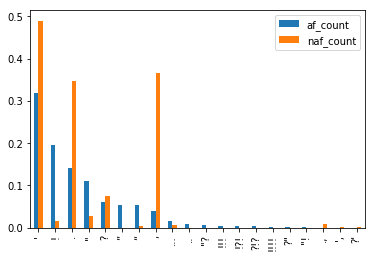

In [12]:
punct_freqs.head(20).plot.bar()
plt.show()